In [1]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt

## Waiting time from state probabilities

##### Theoretical waiting times (for inifinite queue size and infinite threshold)

In [2]:
def probability_no_people_in_the_system(traffic_intensity, num_of_servers):
    denominator = 0
    for i in range(num_of_servers):
        denominator += ((num_of_servers * traffic_intensity) ** i) / math.factorial(i)
    denominator += ((num_of_servers * traffic_intensity) ** num_of_servers) / (math.factorial(num_of_servers) * (1 - traffic_intensity))
    return 1 / denominator

In [3]:
def get_theoretical_waiting_time(Lambda, mu, num_of_servers):
    traffic_intensity = Lambda / (num_of_servers * mu)
    prob_0 = probability_no_people_in_the_system(traffic_intensity, num_of_servers)

    wait = ((num_of_servers * traffic_intensity) ** num_of_servers) / (math.factorial(num_of_servers) * mu * num_of_servers * (1 - traffic_intensity) ** 2)
    wait *= prob_0
    
    return wait

### Waiting times from simulated state probabiliteis - Considering only other arrivals

*Waiting States:*

$$ S_w^o = \{ (u,v) \in S \; | \; v \geq C \} $$

In [4]:
def is_waiting_state_other(state, num_of_servers):
    return (True if state[1] >= num_of_servers else False)

*Accepting States (for other arrivals):*

$$ S_A^o = \{ (u,v) \in S \; | \; v < M \} $$

In [5]:
def is_accepting_state_other(state, system_capacity):
    return (True if state[1] < system_capacity else False)

*Expected waiting time in a state (when ignoring arrivals):*

$$ c(u,v) = \frac{1}{min(v,C) \mu} $$

In [6]:
def expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu):
    return 1 / (min(state[1], num_of_servers) * mu)

*Probability of a transition at state (u,v) being a service:*

$$ P_s(u,v) = 1 $$

<!-- $$ P_s(u,v) = \frac{\text{min}(v,C)\mu}{\text{min}(1, N - v)\lambda^o + \text{ min}(1, M - u)\lambda_A + \text{ min}(v,C)\mu} $$ -->

In [7]:
def probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity):
    
    return 1
#     ambulance_rate = min(1, parking_capacity - state[0]) * lambda_a
#     others_rate = min(1, system_capacity - state[1]) * lambda_o
#     service_rate = min(state[1], num_of_servers) * mu
#     total_rate = ambulance_rate + others_rate + service_rate

#     return service_rate / total_rate

*Waiting time of an individual when arriving at state (u,v):*

$$ 
w(u,v) = 
\begin{cases} 
    0, \hspace{4.85cm} \textbf{if } v < C \\
    c(u,v) + P_s w(u-1, v), \hspace{1cm} \textbf{if } u \geq 1 \textbf{ and } v = t \\
    c(u,v) + P_s w(u, v-1), \hspace{1cm} \textbf{otherwise} \\
\end{cases}
$$

In [8]:
def get_recursive_waiting_time(state, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    if not is_waiting_state_other(state, num_of_servers):
        return 0
    wait = expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu)
    if state[0] >= 1 and state[1] == threshold:
        wait += probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity) * get_recursive_waiting_time((state[0] - 1, state[1]), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        return wait
    
    wait += probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity) * get_recursive_waiting_time((state[0], state[1] - 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return wait

*Mean Waiting Time:*

$$ W = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; w(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [9]:
def mean_waiting_time_formula(all_states, pi, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    mean_waiting_time = 0
    probability_of_accepting = 0
    for u, v in all_states:
        if is_accepting_state_other((u,v), system_capacity):
            current_state_wait = get_recursive_waiting_time((u,v), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
            mean_waiting_time += current_state_wait * pi[u,v]
            probability_of_accepting += pi[u,v]
#             print((u,v), current_state_wait, pi[u,v])
    mean_waiting_time /= probability_of_accepting
    return mean_waiting_time

###### Waiting times from simuation state probabilities

In [10]:
def get_mean_waiting_time_simulation(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num, num_of_trials):
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)
    all_states = [(u,v) for v in range(state_probabilities.shape[1]) for u in range(state_probabilities.shape[0]) if state_probabilities[u,v] > 0]
    mean_waiting_time = mean_waiting_time_formula(all_states, state_probabilities, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return mean_waiting_time

###### Waiting times from markov state probabiliteis

In [11]:
def get_mean_waiting_time_markov(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    transition_matrix = abg.markov.get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    pi = abg.markov.get_steady_state_algebraically(transition_matrix, algebraic_function=np.linalg.solve)
    all_states = abg.markov.build_states(threshold, system_capacity, parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(pi, all_states, output=np.ndarray)
    mean_waiting_time = mean_waiting_time_formula(all_states, state_probabilities, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return mean_waiting_time

## Waiting times from simulated state probabilities - Considering only ambulance arrivals

*Waiting States:*

$$ S_w^A = \{ (u,v) \in S \; | \; u=0 \;, \; C \leq v \leq T \} $$

In [12]:
def is_waiting_state_ambulance(state, num_of_servers, threshold):
    condition = (state[0] == 0 and num_of_servers <= state[1] <= threshold)
    return condition

*Accepting States (for other arrivals):*

$$ S_A^A = \{ (u,v) \in S \; | \; u < N \} $$

In [13]:
def is_accepting_state_ambulance(state, parking_capacity):
    return (True if state[0] < parking_capacity else False)

*Expected waiting time in a state (when ignoring arrivals):*

$$ c(u,v) = \frac{1}{min(v,C) \mu} $$

In [14]:
def expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu):
    return 1 / (min(state[1], num_of_servers) * mu)

*Waiting time of an individual when arriving at state (u,v):*

$$ 
w(u,v) = 
\begin{cases} 
    0, \hspace{4.85cm} \textbf{if } v < C \\
    c(u,v) + P_s w(u-1, v), \hspace{1cm} \textbf{if } u \geq 1 \textbf{ and } v = t \\
    c(u,v) + P_s w(u, v-1), \hspace{1cm} \textbf{otherwise} \\
\end{cases}
$$

In [15]:
def get_recursive_waiting_time_ambulance(state, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    if not is_waiting_state_ambulance(state, num_of_servers, threshold):
        return 0
    wait = expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu)
    if state[0] >= 1 and state[1] == threshold:
        wait += probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity) * get_recursive_waiting_time_ambulance((state[0] - 1, state[1]), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        return wait
    
    wait += probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity) * get_recursive_waiting_time_ambulance((state[0], state[1] - 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return wait

*Mean Waiting Time:*

<!-- $$ P_s(u,v) = \frac{\text{min}(v,C)\mu}{\text{min}(1, N - v)\lambda^o + \text{ min}(1, M - u)\lambda_A + \text{ min}(v,C)\mu} $$ -->

$$ W = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; w(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [16]:
def mean_waiting_time_formula_ambulance(all_states, pi, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    mean_waiting_time = 0
    probability_of_accepting = 0
    for u, v in all_states:
        if is_accepting_state_ambulance((u,v), parking_capacity):
            current_state_wait = get_recursive_waiting_time_ambulance((u,v), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
            mean_waiting_time += current_state_wait * pi[u,v]
            probability_of_accepting += pi[u,v]
#             print((u,v), current_state_wait, pi[u,v])
    mean_waiting_time /= probability_of_accepting
    return mean_waiting_time

*Main functions:*

In [17]:
def get_mean_waiting_time_simulation_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num, num_of_trials):
    if threshold <= num_of_servers:
        return 0
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)
    all_states = [(u,v) for v in range(state_probabilities.shape[1]) for u in range(state_probabilities.shape[0]) if state_probabilities[u,v] > 0]
    mean_waiting_time = mean_waiting_time_formula_ambulance(all_states, state_probabilities, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return mean_waiting_time

In [18]:
def get_mean_waiting_time_markov_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    if threshold <= num_of_servers:
        return 0
    transition_matrix = abg.markov.get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    pi = abg.markov.get_steady_state_algebraically(transition_matrix, algebraic_function=np.linalg.solve)
    all_states = abg.markov.build_states(threshold, system_capacity, parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(pi, all_states, output=np.ndarray)
    mean_waiting_time = mean_waiting_time_formula_ambulance(all_states, state_probabilities, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return mean_waiting_time

##### Plot for comparing all times

In [19]:
def get_plot_comparing_times(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials, seed_num, runtime, system_capacity, parking_capacity, plot_over, max_parameter_value, accuracy=None):
    all_times_sim = []
    all_mean_times_sim = []
    all_mean_times_markov = []
    
    if accuracy == None or accuracy <= 1:
        accuracy = 10
    
    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value , accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value , accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value , accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(num_of_servers, max_parameter_value , max_parameter_value - num_of_servers)
    elif plot_over == "threshold":
        range_space = np.linspace(threshold, max_parameter_value , max_parameter_value - threshold)        
    elif plot_over == "system_capacity":
        range_space = np.linspace(system_capacity, max_parameter_value , max_parameter_value - system_capacity)    
    elif plot_over == "parking_capacity":
        range_space = np.linspace(parking_capacity, max_parameter_value , max_parameter_value - parking_capacity)   
    else: 
        return "Arguement plot_over invalid"
        
#     min_sys_cap = system_capacity
#     max_sys_cap = min_sys_cap + 5
#     sys_cap_space = np.linspace(min_sys_cap, max_sys_cap, max_sys_cap - min_sys_cap + 1, dtype=int)
    
    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_a = parameter
        elif plot_over == "mu":
             mu = parameter
        elif plot_over == "num_of_servers":
             num_of_servers = int(parameter)
        elif plot_over == "threshold":
             threshold = int(parameter)
        elif plot_over == "system_capacity":
             system_capacity = int(parameter)
        elif plot_over == "parking_capacity":
             parking_capacity = int(parameter)
                
        times = abg.simulation.get_multiple_runs_results(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials=num_of_trials, seed_num=seed_num, runtime=runtime, system_capacity=system_capacity, parking_capacity=parking_capacity)
        simulation_waiting_times = [np.mean(w.waiting_times) for w in times]

        mean_waiting_time_sim = get_mean_waiting_time_simulation(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)
        mean_waiting_time_markov = get_mean_waiting_time_markov(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

        all_times_sim.append(simulation_waiting_times)
        all_mean_times_sim.append(mean_waiting_time_sim)
        all_mean_times_markov.append(mean_waiting_time_markov)
        
    diff = (range_space[1] - range_space[0]) / 2
    
    plt.figure(figsize=(20,10))
    plt.plot(range_space, all_mean_times_sim, label="Simulation State probabilities")
    plt.plot(range_space, all_mean_times_markov, label="Markov State probabilities")
    plt.violinplot(all_times_sim, positions=range_space, widths=diff, showmeans=True, showmedians=False)
    title = "λa=" + str(lambda_a) + ", λo=" +str(lambda_o) + ", μ=" + str(mu) + ", C=" + str(num_of_servers) + ", T=" + str(threshold) + ", N=" + str(system_capacity) + ", M=" + str(parking_capacity)
    plt.title(title)
    plt.xlabel("System capacity")
    plt.ylabel("Waiting time")
    plt.legend()
    plt.show()
    return range_space, all_mean_times_sim, all_mean_times_markov, all_times_sim

In [20]:
def get_plot_comparing_times_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials, seed_num, runtime, system_capacity, parking_capacity, plot_over, max_parameter_value, accuracy=None):
    all_times_sim = []
    all_mean_times_sim = []
    all_mean_times_markov = []
    
    if accuracy == None or accuracy <= 1:
        accuracy = 10
    
    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value , accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value , accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value , accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(num_of_servers, max_parameter_value , max_parameter_value - num_of_servers)
    elif plot_over == "threshold":
        range_space = np.linspace(threshold, max_parameter_value , max_parameter_value - threshold)        
    elif plot_over == "system_capacity":
        range_space = np.linspace(system_capacity, max_parameter_value , max_parameter_value - system_capacity)    
    elif plot_over == "parking_capacity":
        range_space = np.linspace(parking_capacity, max_parameter_value , max_parameter_value - parking_capacity)   
    else: 
        return "Arguement plot_over invalid"
        
#     min_sys_cap = system_capacity
#     max_sys_cap = min_sys_cap + 5
#     sys_cap_space = np.linspace(min_sys_cap, max_sys_cap, max_sys_cap - min_sys_cap + 1, dtype=int)
    
    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_a = parameter
        elif plot_over == "mu":
             mu = parameter
        elif plot_over == "num_of_servers":
             num_of_servers = int(parameter)
        elif plot_over == "threshold":
             threshold = int(parameter)
        elif plot_over == "system_capacity":
             system_capacity = int(parameter)
        elif plot_over == "parking_capacity":
             parking_capacity = int(parameter)
                
        times = abg.simulation.get_multiple_runs_results(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials=num_of_trials, seed_num=seed_num, runtime=runtime, system_capacity=system_capacity, parking_capacity=parking_capacity)
        simulation_waiting_times = [np.mean(w.waiting_times) for w in times]

        mean_waiting_time_sim = get_mean_waiting_time_simulation_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)
        mean_waiting_time_markov = get_mean_waiting_time_markov_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

        all_times_sim.append(simulation_waiting_times)
        all_mean_times_sim.append(mean_waiting_time_sim)
        all_mean_times_markov.append(mean_waiting_time_markov)
        
    diff = (range_space[1] - range_space[0]) / 2
    
    plt.figure(figsize=(20,10))
    plt.plot(range_space, all_mean_times_sim, label="Simulation State probabilities")
    plt.plot(range_space, all_mean_times_markov, label="Markov State probabilities")
    plt.violinplot(all_times_sim, positions=range_space, widths=diff, showmeans=True, showmedians=False)
    title = "λa=" + str(lambda_a) + ", λo=" +str(lambda_o) + ", μ=" + str(mu) + ", C=" + str(num_of_servers) + ", T=" + str(threshold) + ", N=" + str(system_capacity) + ", M=" + str(parking_capacity)
    plt.title(title)
    plt.xlabel("System capacity")
    plt.ylabel("Waiting time")
    plt.legend()
    plt.show()
    return range_space, all_mean_times_sim, all_mean_times_markov, all_times_sim

## Comparing Results (No ambulance arrivals)

In [21]:
lambda_a = 0.000001
lambda_o = 0.3
mu = 0.1
num_of_servers = 4
threshold = 3
system_capacity = 10
parking_capacity = 10

num_of_trials = 20
seed_num = 0
runtime = 10000

##### Compare state probabilities

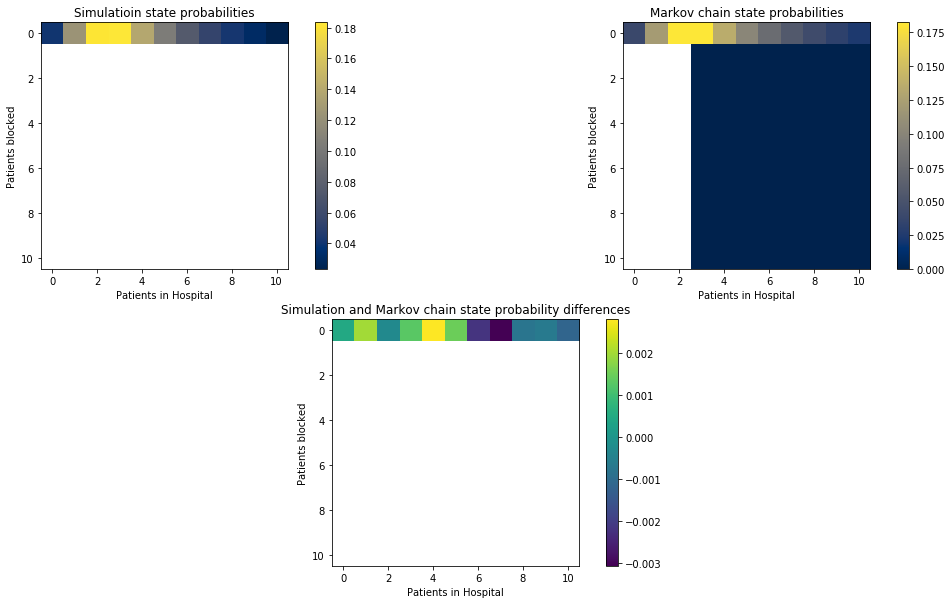

In [620]:
plt.figure(figsize=(20,10))
abg.get_heatmaps(lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers, threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity, seed_num=seed_num, runtime=runtime, num_of_trials=num_of_trials)

##### Compare Times

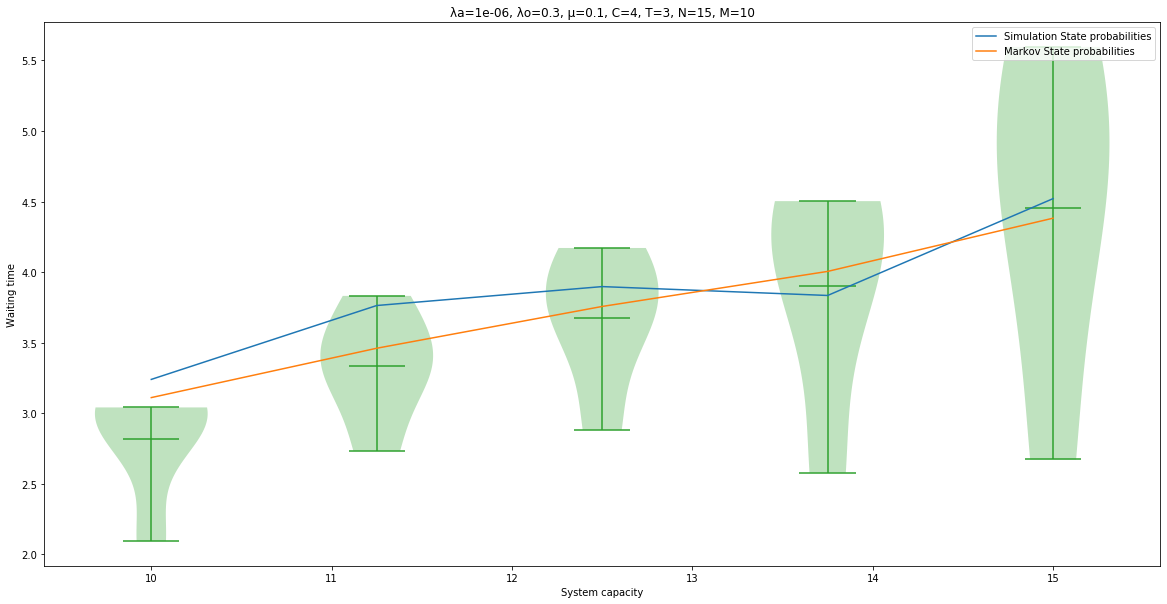

In [23]:
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(lambda_a, lambda_o, mu, num_of_servers, threshold, 5, 0, runtime, system_capacity, parking_capacity, "system_capacity", system_capacity+5)

## Comparing results (No other arrivals)

In [10]:
lambda_a = 0.3
lambda_o = 0.0000001
mu = 0.1
num_of_servers = 5
threshold = 5
system_capacity = 20
parking_capacity = 20

num_of_trials = 5
seed_num = 0
runtime = 10000

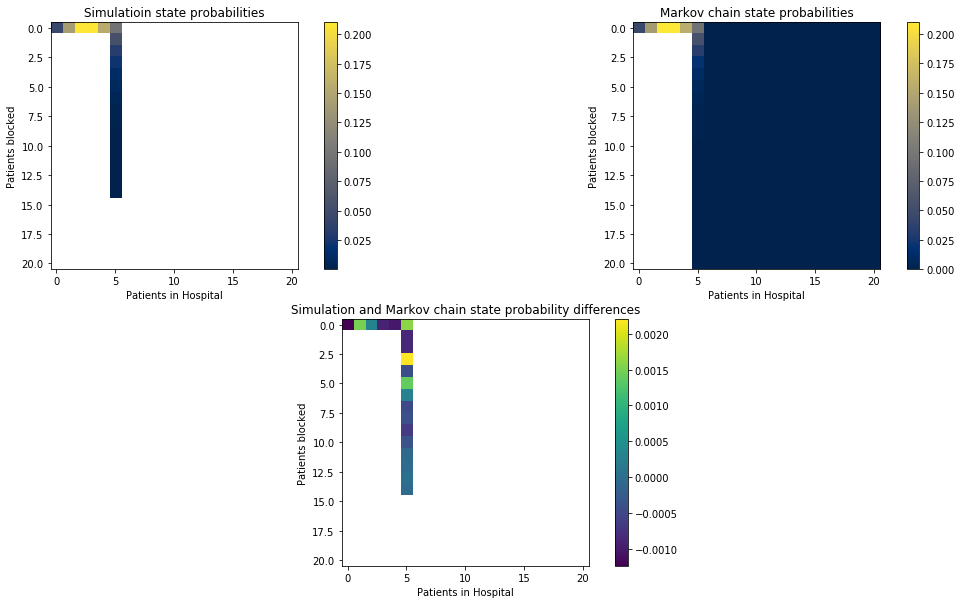

In [11]:
plt.figure(figsize=(20,10))
abg.get_heatmaps(lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers, threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity, seed_num=seed_num, runtime=runtime, num_of_trials=num_of_trials)

##### Simulated waiting time

In [12]:
times = abg.simulation.get_multiple_runs_results(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials=num_of_trials, seed_num=seed_num, runtime=runtime, system_capacity=system_capacity, parking_capacity=parking_capacity)
mean_waiting_time = np.mean([np.mean(w.waiting_times) for w in times])
print(mean_waiting_time)

0.0


##### Waiting time from simulated state probabilities

In [13]:
get_mean_waiting_time_simulation_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)

0

###### Waiting time from markov state probabilities

In [14]:
get_mean_waiting_time_markov_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

0

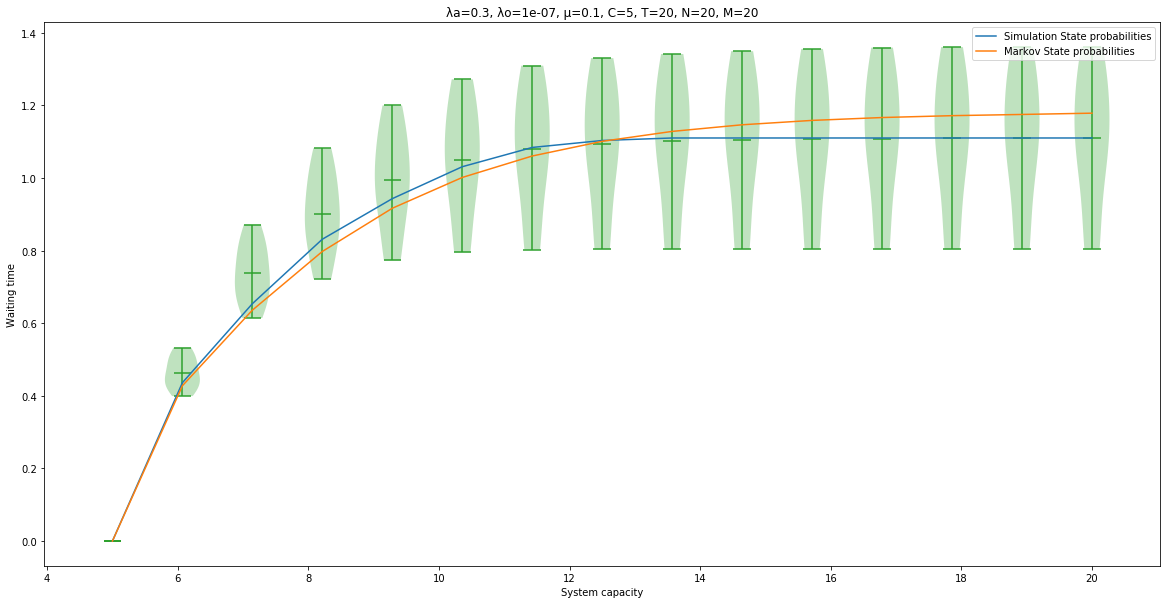

In [17]:
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times_ambulance(lambda_a, lambda_o, mu, num_of_servers, threshold, 10, 0, runtime, system_capacity, parking_capacity, "threshold", threshold+15)